# Generic Pseudo-labeling for Domain Adaptation in Deep Computer Vision

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Directory Structure

The project is structured as follows:

Main files:
- domain_adaptation.ipynb: is the main Jupyter Notebook containing the project code
- report.pdf: Supplemental material containing Figures, Tables and analysis on the results of the project
  
Directories:
- lib: a library of general functions for Data Science tasks
- tasks: task-specific modules
- data: the input data
- output: the model training output
- results: Graphs, Tables and Figures produced in the project
- scripts: pre-processing scripts applied to the data

Notes:

* This notebook mainly discusses the implementation and design decisions of the project. For the theory, experimental procedures
and results, consult [the main report](report.pdf).

* This notebook does not contain the fundamental code for preprocessing, loading data, training models, implementing the pseudo-labeling procedure
or our incremental learning algorithm. The code, as well as extensive comments and documentation, exist in the respective source files in the
`tasks` and `lib` directories.

## Modern Office Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output/office"

RANDOM_SEED = 42
BATCH_SIZE = 1
PRINT_STATS_PERIOD = 500

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

RHO = 4
SAMPLING_PERIOD = 20


FINETUNED_SOURCE__MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
FINETUNED_TARGET_MODEL_DIR = os.path.join(OUTPUT_DIR, "target_classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-20")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-20")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-10")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-10")

FINETUNE_SOURCE_MODEL = False
FINETUNE_TARGET_MODEL = False
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
TRAIN_SEMI_SUPERVISED_MODEL_20 = False
FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
TRAIN_SEMI_SUPERVISED_MODEL_10 = False

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset preprocessing

Most of the work here is done through the ImageDataset class, which lazy loads all images from the given root directory. 

We import the data from the source dataset (Modern Office-31 Amazon domain)...

In [2]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

source_train_loader = tasks.preprocessing.single_batch_loader(
    source_train_dataset, shuffle=True
)
source_val_loader = tasks.preprocessing.single_batch_loader(
    source_val_dataset, shuffle=False
)
source_test_loader = tasks.preprocessing.single_batch_loader(
    source_test_dataset, shuffle=False
)

  0%|          | 0/31 [00:00<?, ?it/s]

... and the respective target dataset (Modern Office-31 Webcam domain).

In [3]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.single_batch_loader(
    target_train_dataset, shuffle=True
)
target_val_loader = tasks.preprocessing.single_batch_loader(
    target_val_dataset, shuffle=False
)
target_test_loader = tasks.preprocessing.single_batch_loader(
    target_test_dataset, shuffle=False
)

  0%|          | 0/31 [00:00<?, ?it/s]

We now import convert the target domain data into unlabelled and labelled datasets. 

We use a stratified split for all classes, converting 10%/20% of the target domain samples into labelled data and then adding them to the source domain dataset.

In [4]:
unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset_20.load_from_image_dataset(target_train_dataset)

to_be_unlabeled_dataset_20, labeled_dataset_20 = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_20.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_20.load_from_image_dataset(to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_20.add(sample_img, sample_label)

len(labeled_dataset_20), len(source_train_dataset)

(2224, 2112)

In [5]:
to_be_unlabeled_dataset_10, labeled_dataset_10 = lib.data.stratified_split(
    target_train_dataset, test_size=0.1
)

unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_10.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_10.load_from_image_dataset(to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_10.add(sample_img, sample_label)

len(labeled_dataset_10), len(source_train_dataset)

(2168, 2112)

In [6]:
class_names = source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

### Source-only model

We will be using the ResNet-18 model, pre-trained on the ImageNet dataset. 

From our experience, keeping the pre-trained classification head of 1000 classes actually significantly speeds up training and avoids overfitting. Thus, we do not replace it with our own 31-class dense layer.

In [7]:
import torchinfo


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(tasks.utils.get_model(device=device), input_size=(BATCH_SIZE, 3, 1500, 1500))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 750, 750]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 750, 750]         128
├─ReLU: 1-3                              [1, 64, 750, 750]         --
├─MaxPool2d: 1-4                         [1, 64, 375, 375]         --
├─Sequential: 1-5                        [1, 64, 375, 375]         --
│    └─BasicBlock: 2-1                   [1, 64, 375, 375]         --
│    │    └─Conv2d: 3-1                  [1, 64, 375, 375]         36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 375, 375]         128
│    │    └─ReLU: 3-3                    [1, 64, 375, 375]         --
│    │    └─Conv2d: 3-4                  [1, 64, 375, 375]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 375, 375]         128
│    │    └─ReLU: 3-6                    [1, 64, 375, 375]         --
│

We finetune the pretrained model on the source domain dataset (Amazon domain):

In [8]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SOURCE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_SOURCE__MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


And print the learning curves as well as the classification results on both source and target domain test sets:

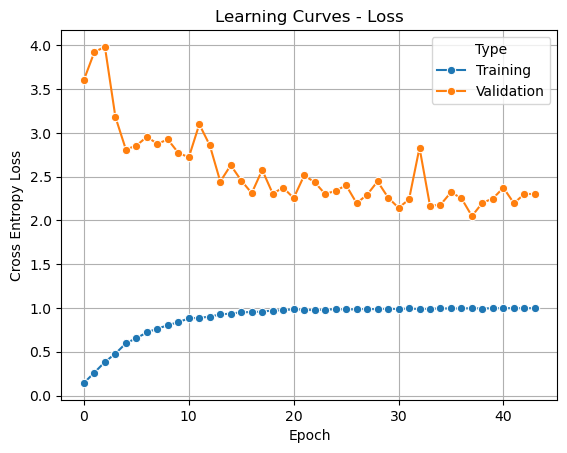

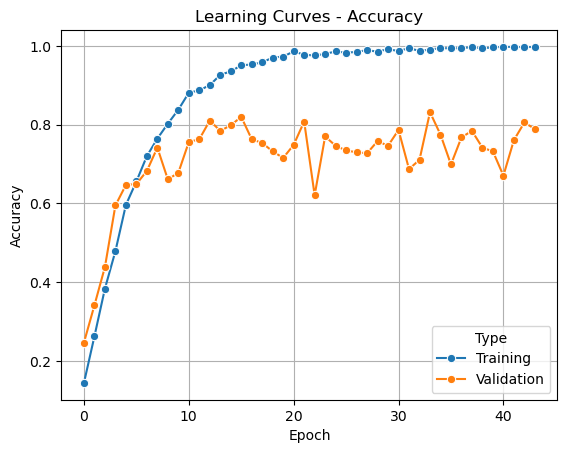

In [9]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

  0%|          | 0/283 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.78      1.00      0.88         7
            bike       1.00      1.00      1.00         5
     bike_helmet       1.00      1.00      1.00         7
        bookcase       0.78      1.00      0.88         7
          bottle       0.50      0.75      0.60         4
      calculator       0.80      1.00      0.89         8
      desk_chair       0.91      1.00      0.95        10
       desk_lamp       0.89      1.00      0.94         8
desktop_computer       0.85      0.85      0.85        13
    file_cabinet       1.00      0.70      0.82        10
      headphones       1.00      0.60      0.75         5
        keyboard       0.89      1.00      0.94        17
 laptop_computer       0.93      1.00      0.96        13
     letter_tray       1.00      0.50      0.67         6
    mobile_phone       1.00      0.89      0.94         9
         monitor       1.00      1.00      1.00         9
           mo

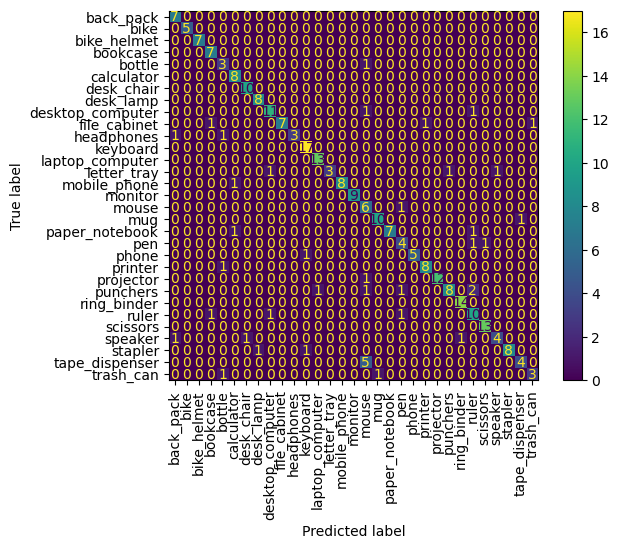

In [10]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.67      0.40      0.50         5
            bike       1.00      0.50      0.67         2
     bike_helmet       0.60      0.75      0.67         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       1.00      0.50      0.67         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.67      0.67      0.67         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

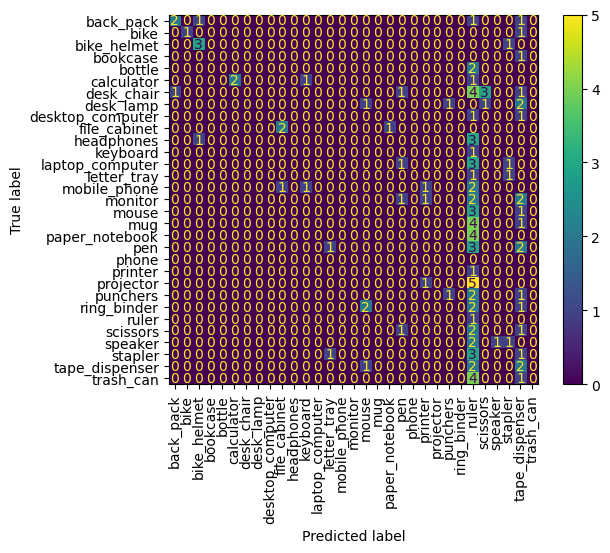

In [11]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

We can clearly see that our baseline, the source-only model, can not effectively distinguish between any of the classes (except for the first few).

### Target only model

The procedure described above is repeated for the model trained on the target domain.

In [12]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(encodings))

if FINETUNE_TARGET_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=10e-3)

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        target_train_loader,
        target_val_loader,
        output_dir=FINETUNED_TARGET_MODEL_DIR,
        num_epochs=100,
        patience=10,
        warmup_period=25,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=20000,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


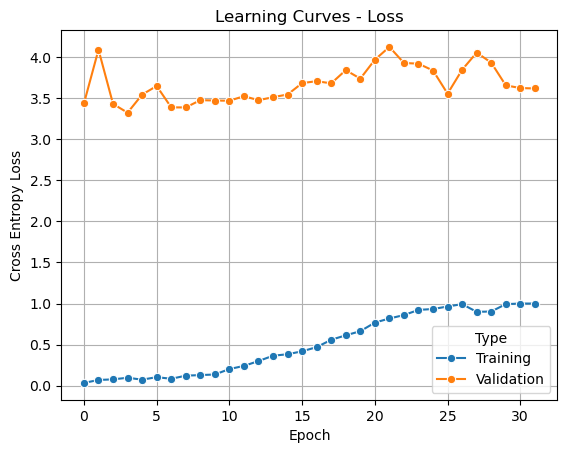

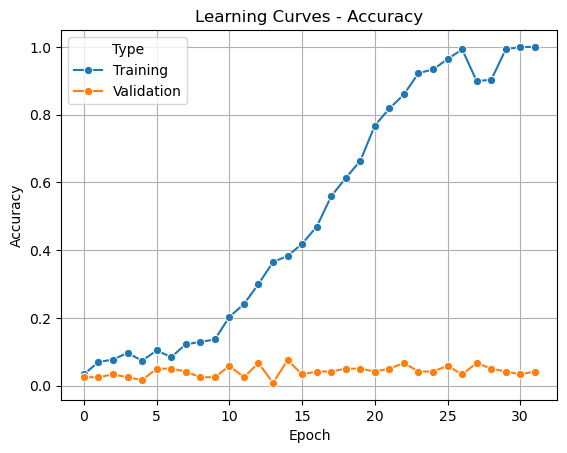

In [13]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.04      0.50      0.08         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.00      0.00      0.00         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

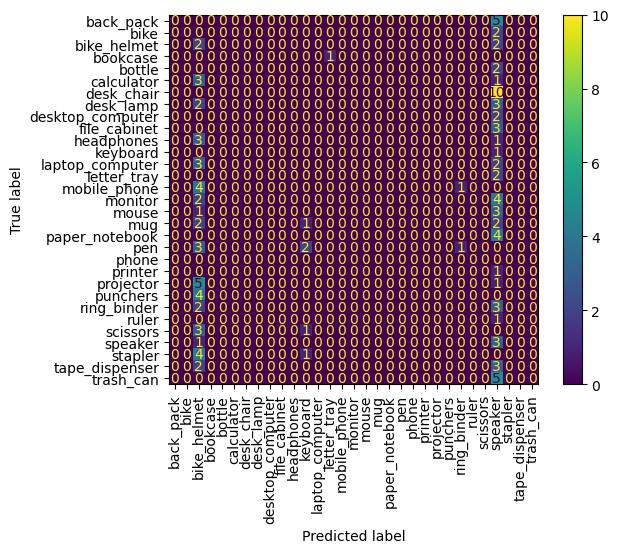

In [14]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

Surprisingly, there is no way we can effectively train the target-only model which was supposed to be our baseline. 
Due to the low number of datapoints and the difficulty of the domain, it immediately overfits. No amount of increasing regularization
(such as AdamW with weight_decay=$10^{-2}$) seems to influence the results. Additionally, we can not use data augmentation, since that
would make the comparison between models unfair.

### Unsupervised Domain Adaptation

Having trained and evaluated our baselines, we can begin experimenting with the incremental learning procedure:

In [15]:
model = tasks.utils.get_model(device=device)

if TRAIN_UNSUPERVISED_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    model = tasks.utils.try_load_weights(
        model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt")
    )
    optimizer_ft = optim.Adam(model.parameters())

    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=source_train_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


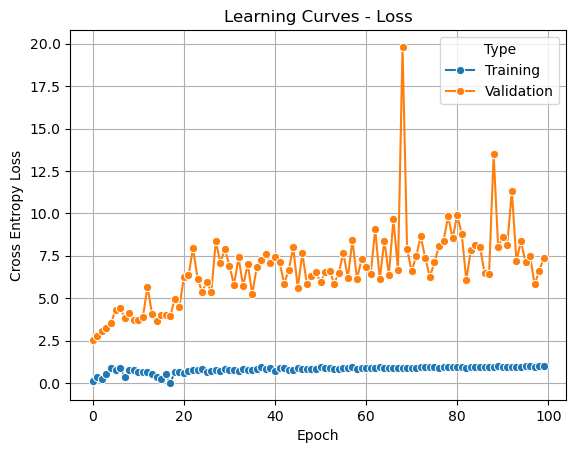

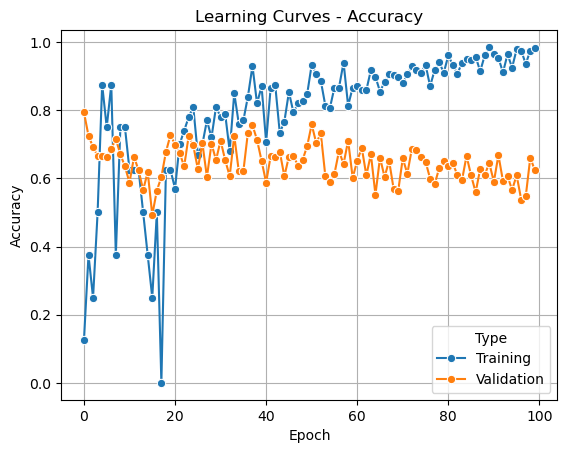

In [16]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

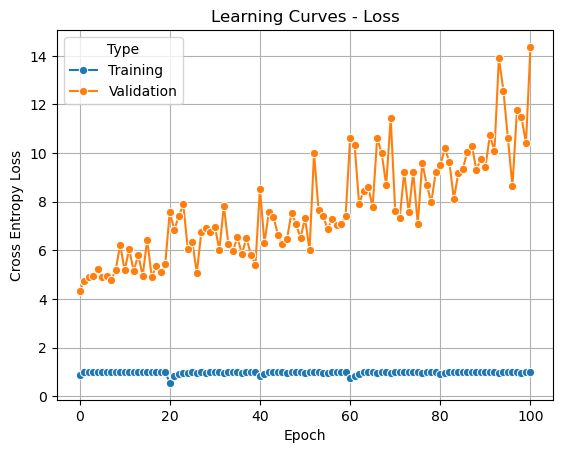

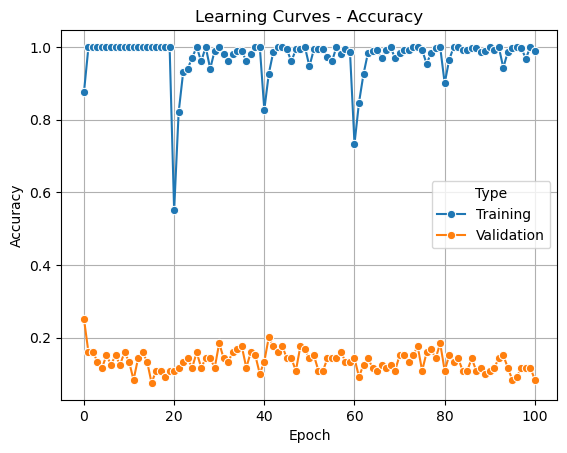

In [17]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

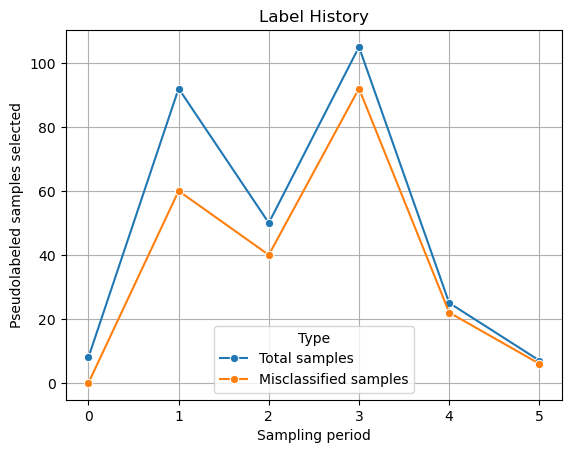

In [18]:
tasks.results.plot_label_history(label_history, encodings)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.60      0.60      0.60         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.60      0.75      0.67         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.50      0.25      0.33         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.25      0.40      0.31         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.33      0.20      0.25         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

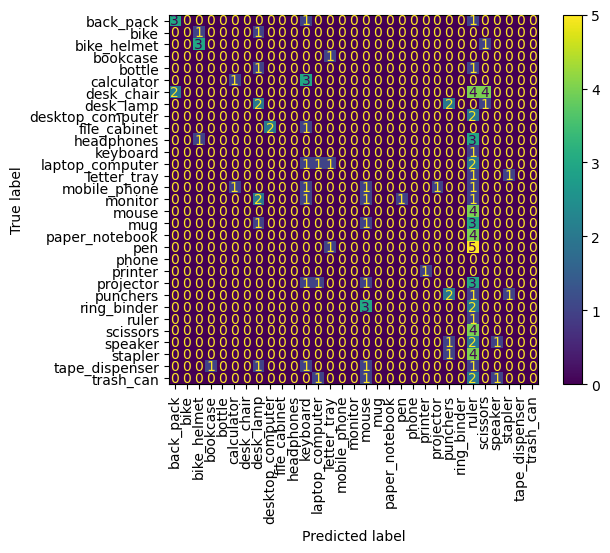

In [19]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 10% target data

In [20]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=None,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


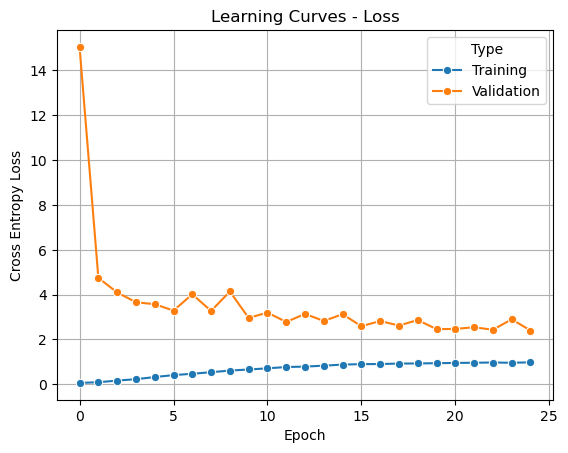

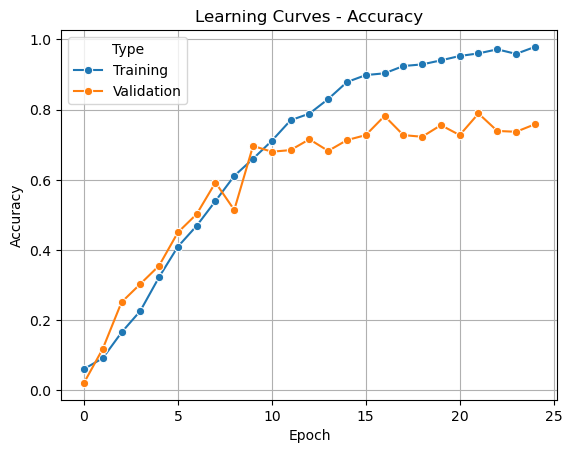

In [21]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.75      0.60      0.67         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.67      0.50      0.57         4
        bookcase       1.00      1.00      1.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.33      0.50      0.40         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.40      0.57         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.33      0.40      0.36         5
         monitor       0.00      0.00      0.00         6
           mo

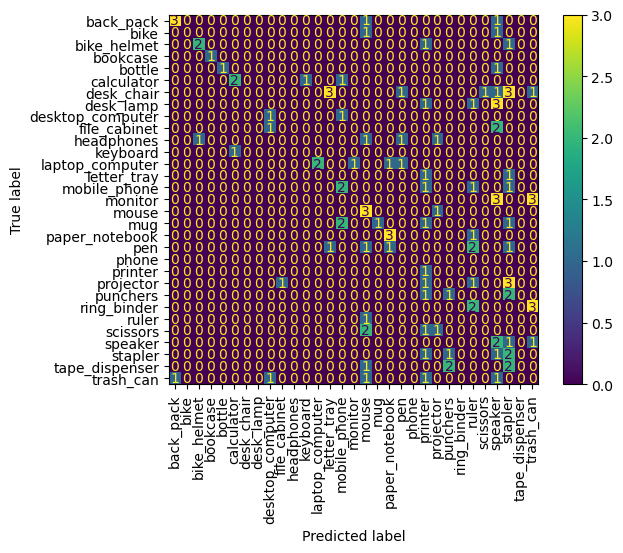

In [22]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [23]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_10:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_10,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_10,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=None,
            previous_target_history=None,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


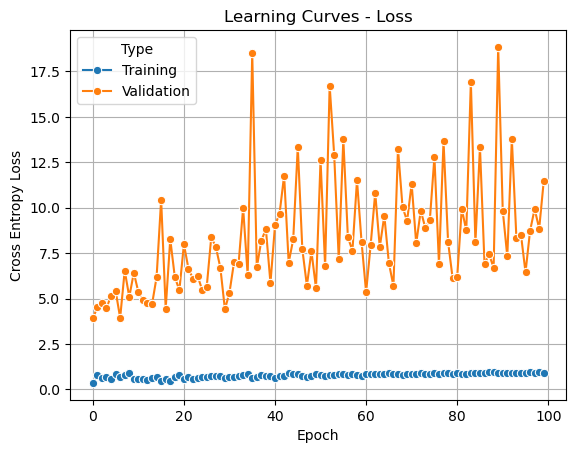

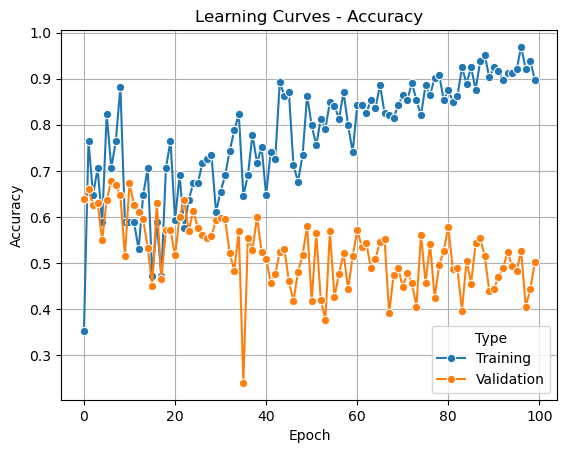

In [24]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

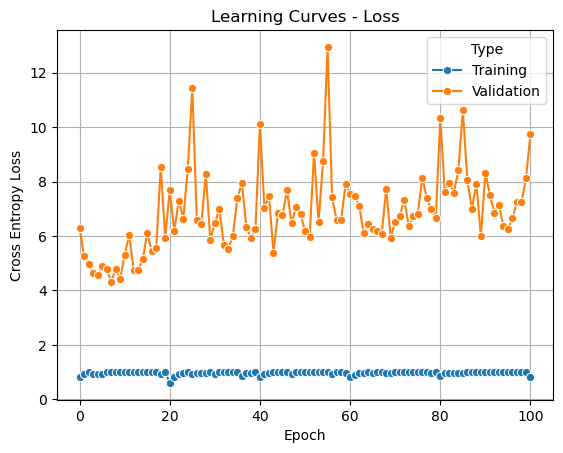

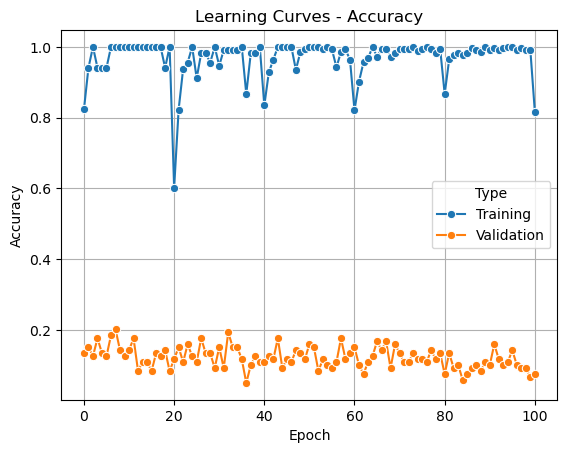

In [25]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

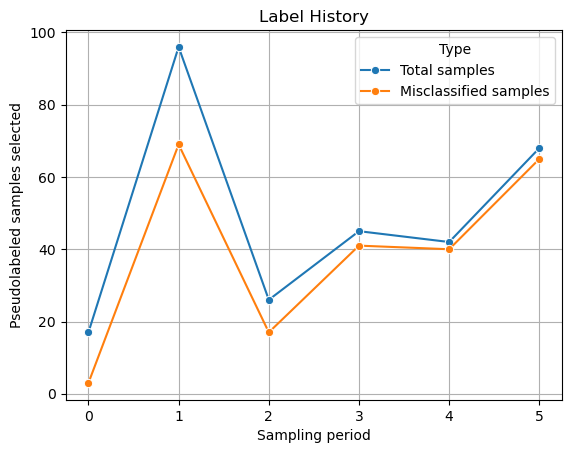

In [26]:
tasks.results.plot_label_history(label_history, encodings)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.60      0.75         5
            bike       1.00      0.50      0.67         2
     bike_helmet       0.33      0.50      0.40         4
        bookcase       0.25      1.00      0.40         1
          bottle       0.00      0.00      0.00         2
      calculator       1.00      0.75      0.86         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

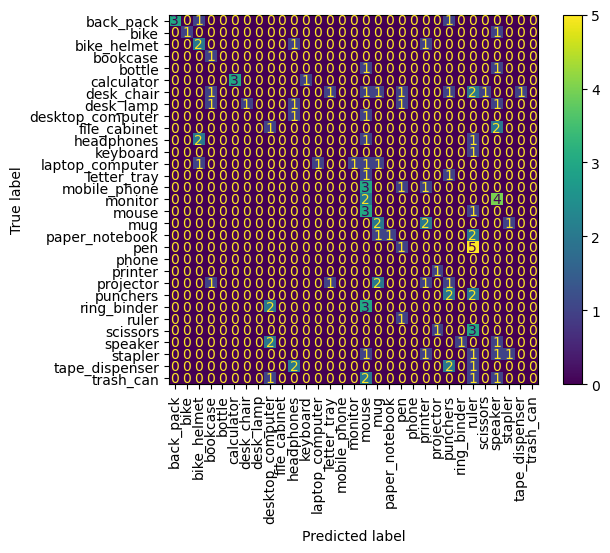

In [27]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 20% target data

In [28]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


No history found in path  output/office/semi-supervised-finetuned-20/label_history.pickle


  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.80      0.89         5
            bike       1.00      1.00      1.00         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       1.00      0.40      0.57         5
desktop_computer       0.20      0.50      0.29         2
    file_cabinet       1.00      0.33      0.50         3
      headphones       0.67      0.50      0.57         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.40      0.40      0.40         5
         monitor       0.00      0.00      0.00         6
           mo

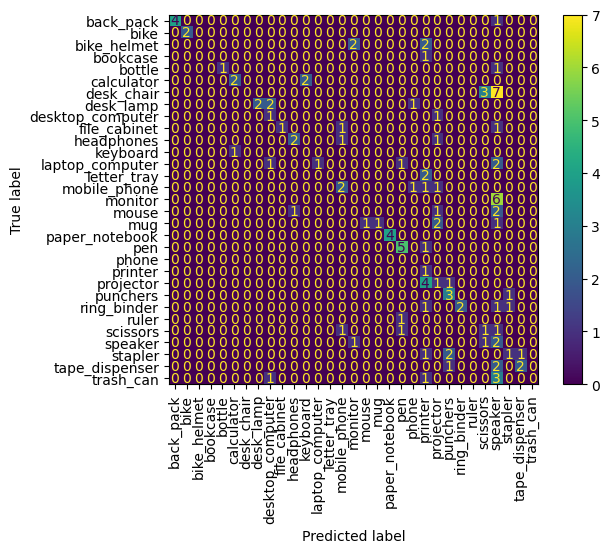

In [29]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [30]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    source_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.single_batch_loader(
                dataset, sampler=sampler, shuffle=False
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


No weights found in path  output/office/semi-supervised-adaptive-20/model.pt 
 [Errno 2] No such file or directory: 'output/office/semi-supervised-adaptive-20/model.pt'
No history found in path  output/office/semi-supervised-adaptive-20/source_history.pickle
No history found in path  output/office/semi-supervised-adaptive-20/target_history.pickle
No history found in path  output/office/semi-supervised-adaptive-20/label_history.pickle


In [31]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## MNIST/MNIST-M dataset

The following code is near-identical to the one running the models on the Modern Office-31 dataset. 

* We slightly change hyperparameters because of the different nature of the dataset (batch size, $\rho$, weight decay...)
* We change the optimizer from Adam to AdamW (since the second implements weight decay in a mathematically correct manner)
* We swap the classification head from the 1000 classes to 10 since:
    * There is no correlation between the MNIST and ImageNet classes
    * It makes the model smaller and thus harder to overfit, which is likely given the comparatively easier task of MNIST classification
* We do not use pretrained weights

In [ ]:
BATCH_SIZE = 16
WEIGHT_DECAY = 10e-6
RHO = 3

AD_DATA_DIR = "data/digits"
AD_OUTPUT_DIR = "output/digits"

AD_SOURCE_DATASET = "mnist"
AD_TARGET_DATASET = "mnist-m"

AD_FINETUNED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "classifier")
AD_FINETUNED_TARGET_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "target_classifier")
AD_UNSUPERVISED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "unsupervised")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-20")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-20")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-10")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-10")

AD_FINETUNE_MODEL = False
AD_FINETUNE_TARGET_MODEL = False
AD_TRAIN_UNSUPERVISED_MODEL = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_20 = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_10 = False

### Dataset preprocessing

In [ ]:
ad_source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_source_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_SOURCE_DATASET))

ad_source_train_dataset, ad_source_val_dataset, ad_source_test_dataset = (
    lib.data.train_val_test_split(
        ad_source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

ad_source_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_source_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_source_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

In [ ]:
ad_target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=ad_source_dataset.label_encoder,  # use same classes
)
ad_target_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_TARGET_DATASET))

ad_target_train_dataset, ad_target_val_dataset, ad_target_test_dataset = (
    lib.data.train_val_test_split(
        ad_target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

ad_target_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_target_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_target_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

In [ ]:
ad_unlabeled_dataset = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset.load_from_image_dataset(ad_target_train_dataset)

In [ ]:
ad_to_be_unlabeled_dataset_10, ad_labeled_dataset_10 = lib.data.stratified_split(
    ad_target_train_dataset, test_size=0.1
)

ad_unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_10.parser_func,
    preprocessing_func=ad_source_dataset.preprocessing_func,
)
ad_unlabeled_dataset_10.load_from_image_dataset(ad_to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_10.add(sample_img, sample_label)

len(ad_labeled_dataset_10), len(ad_source_train_dataset)

In [ ]:
ad_unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset_20.load_from_image_dataset(ad_target_train_dataset)

ad_to_be_unlabeled_dataset_20, ad_labeled_dataset_20 = lib.data.stratified_split(
    ad_target_train_dataset, test_size=0.2
)

ad_unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_20.parser_func,
    preprocessing_func=ad_labeled_dataset_20.preprocessing_func,
)
ad_unlabeled_dataset_20.load_from_image_dataset(ad_to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_20.add(sample_img, sample_label)

len(ad_labeled_dataset_20), len(ad_source_train_dataset)

In [ ]:
class_names = ad_source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(ad_source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [ ]:
import torchinfo


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(tasks.utils.get_model(device=device,
                                        replace_fc_layer=True,
                                        num_classes=len(encodings)),
                                        input_size=(BATCH_SIZE, 3, 30, 30))

In [ ]:
model = tasks.utils.get_model(device=device,
                            replace_fc_layer=True,
                            num_classes=len(encodings),
                            use_default_weights=False)

if AD_FINETUNE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_source_train_loader,
        ad_source_val_loader,
        output_dir=AD_FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Target only model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(encodings))

if  AD_FINETUNE_TARGET_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_target_train_loader,
        ad_target_val_loader,
        output_dir=AD_FINETUNED_TARGET_MODEL_DIR,
        num_epochs=15,
        patience=3,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

### Unsupervised Domain Adaptation

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_UNSUPERVISED_MODEL:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_source_train_dataset,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, AD_UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Semi Supervised 10%

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=1,
        previous_history=history,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_10:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_10,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_10,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Supervised 20%

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=1,
        previous_history=history,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_20:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_20,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_20,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)